# tehagenaci: ročníkový projekt

## O projekte
**Názov**: Testovanie hardvérových generátorov náhodných čísel

### Študent
**Meno**: Anton Kica

**Email**: kica6@uniba.sk


### Školiaci
**Meno**: RNDr. Richard Ostertág, PhD.

**Email**: ostertag@dcs.fmph.uniba.sk

### Ciele projektu

1. Vyvinúť alebo nájsť vhodné existujúce aplikácie pre testovanie kvality náhodných generátorov

2. Získať náhodné dáta zo zvolených HW generátorov za rôznych podmienok, otestovať kvalitu súčiastok a pozorovať prípadné zmeny parametrov

### Priečinok src/ v repozitári
- src/arduino 
    - zdrojový kód pre generovanie vzorky pomocou arduina a cryptoshieldu
- src/lcg-generators
    - zdrojový kód pre generovanie vzoriek _ZX81_ a _numerical-recipes_ pomocou algoritmu lcg
- src/processor
    - zdrovový kód pre spracovanie vygenerovaných vzoriek
    - obsahuje jednoduché testy pre testovanie korektnosti kódu

## Tak ku projektu...

Naša práca pozostávala z troch štadií
1. Generovanie vzoriek
2. Spracovanie vygenerovaných vzoriek
3. Analýza údajov zo vzoriek a záver

### Generovanie vzoriek

Našou úlohou bolo otestovať súčiastku ATECC108, teda posúdiť kvalitu generovaných náhodných čísel za rozličných podmienok.
Rozhodli sme sa túto súčiastku testovať v troch prostrediach s rozličnými teplotami - 0°C, 21°C a 40°C. 

Tiež sme sa pre referenciu rozhodli softvérovo vygenerovať vzorky náhodných čísel, ktoré sú zdanlivo náhodné, no ako uvidíme, nie úplne.

#### ATECC108 vzorky
![atecc108](./images/atecc108.jpg)
Pomocou dosky [Ardunino UNO SMD rev. 3x](https://store.arduino.cc/products/arduino-uno-rev3), shieldu [SparkFun CryptoShield](https://www.sparkfun.com/products/retired/13183) a jeho komponentu [ATECC108](http://ww1.microchip.com/downloads/en/DeviceDoc/Atmel-8873S-CryptoAuth-ATECC108-Datasheet-Summary.pdf) sme za pomoci knižnice [cryptoauth-arduino](https://github.com/cryptotronix/cryptoauth-arduino) vygenerovali nasledujúce vzorky:

|názov vzorky|prostredie|teplota|veľkosť vzorky v MB|
|-|-|-|-|
|normal-short| izbová teplota |21°|243|
|normal-long | izbová teplota |21°|870|
|cold        | znížená teplota|0° |257|
|hot         | vyššia teplota |40°|243|

#### LCG vzorky
[LCG](https://en.wikipedia.org/wiki/Linear_congruential_generator)(Linear Congruential Generator) je jednoduchý algoritmus na generovanie pseudonáhodných čísel, má jednoduchú rekurzívnu definíciu:

${\displaystyle X_{n+1}=\left(aX_{n}+c\right){\bmod {m}}}$

kde $a$, $c$ a $m$ sú konštanty a $X_{0}$ je semienko.

|názov vzorky|a|c|m|$X_{0}$|veľkosť vzorky v MB|
|-|-|-|-|-|-|
|ZX81             |75     |74        |2^16 + 1|12|256|
|numerical-recipes|1664525|1013904223|2^32    |12|256|


# Spracovanie vzoriek

Pre vygenerované vzorky vypočítame rôzne $n×m$ matice. Táto matica nám hovorí, koľko m-tic nasledovalo po jednej n-tici. Pričom $n$-tica a $m$-tica sú v tomto prípade bitové vektory.

Maticu $n×m$ počítame teda takto:
![math](./images/math.png)

In [1]:
import os

input_atecc108 = 'output-atecc108'
input_lcg = 'output-lcg'

example_file = os.path.join(input_atecc108, sorted(os.listdir(input_atecc108))[0])
print("Opening example file: " + example_file)
print(open(example_file, 'r').read())

Opening example file: output-atecc108/2-1
4
00 01 10 11 
0 1 
cold
1074037211
134234434 134252528 268486962
134268427 134250628 268519055
134236650 134273175 268509825
134257276 134264093 268521369
normal-long
3646396955
455771503 455783637 911555140
455808724 455824443 911633167
455767841 455822631 911590472
455797545 455820631 911618176
hot
1015676371
126965119 126952753 253917872
126960613 126961829 253922442
126953778 126965290 253919068
126957430 126959559 253916989
normal-short
1015118579
126887428 126886149 253773577
126894506 126882507 253777013
126910673 126885863 253796536
126877506 126893947 253771453



Takto vyzerá výstup jednej konkrétnej $n×m$ matice pre 4 vzorky. (Nie nerobili sme výpočty ručne ako by obrázok mohol naznačovať).

Následne tieto dáta vieme zobraziť pomocou [Pythonu](https://www.python.org) a knižníc [numpy](https://numpy.org) a [matplotlib](https://matplotlib.org):

In [2]:
import sys
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


def process_files(output_dir):
    files = sorted(os.listdir(output_dir))
    for file_index in range(0, len(files)):
        file = open(os.path.join(output_dir, files[file_index]), 'rb')

        name_split = files[file_index].split("-")
        lhs_bitcount = int(name_split[0])
        rhs_bitcount = int(name_split[1])

        sample_count = int(file.readline())
        lhs = file.readline().strip().decode("ASCII").split()
        rhs = file.readline().strip().decode("ASCII").split()

        fig, ax = plt.subplots(ncols=sample_count, figsize=(40,15))

        for sample_index in range(0, sample_count):
            sample_name = file.readline().strip().decode("ASCII")
            sample_cnt = int(file.readline())
            sample_cnts = []
            sample_stats = np.empty((0, len(rhs)), int)
            

            for stat_row in range(0, len(lhs)):
                line_data = file.readline().split()
                line_nums = [int(n) for n in line_data[:-1]]
                line_sum = int(line_data[-1])                
                sample_cnts.append(line_sum)
                sample_stats = np.append(sample_stats, np.array([line_nums]), axis=0)

            im = ax[sample_index].imshow( [n / sample_cnt for n in sample_stats], cmap='coolwarm', interpolation='nearest')

            sample_lhs = []
            for stat_row in range(0, len(lhs)):
                sample_lhs.append('{0}\n ({1:.4f})%'.format(lhs[stat_row], sample_cnts[stat_row] / sample_cnt * 100))
            
            ax[sample_index].set_xticks(np.arange(len(rhs)), labels=rhs)
            ax[sample_index].set_yticks(np.arange(len(sample_lhs)), labels=sample_lhs)
            ax[sample_index].set_title(sample_name)

            for i in range(len(lhs)):
                for j in range(len(rhs)):
                    actual=sample_stats[i, j] / sample_cnts[i]
                    expected=1/len(rhs)
                    ax[sample_index].text(j, i, '{0:.4f}%'.format((actual-expected) * 100), ha="center", va="center", color="black")
            fig.tight_layout()

        plt.suptitle(f"{lhs_bitcount} -> {rhs_bitcount}", fontweight="bold")
        plt.show()

## Spracované vzorky
Jednoduché vysvetlenie:
- farba do červená je väčšie množstvo, než očakávané
- farba do modra je menšie množstvo, než očakávané

### Spracované vzorky ATECC108

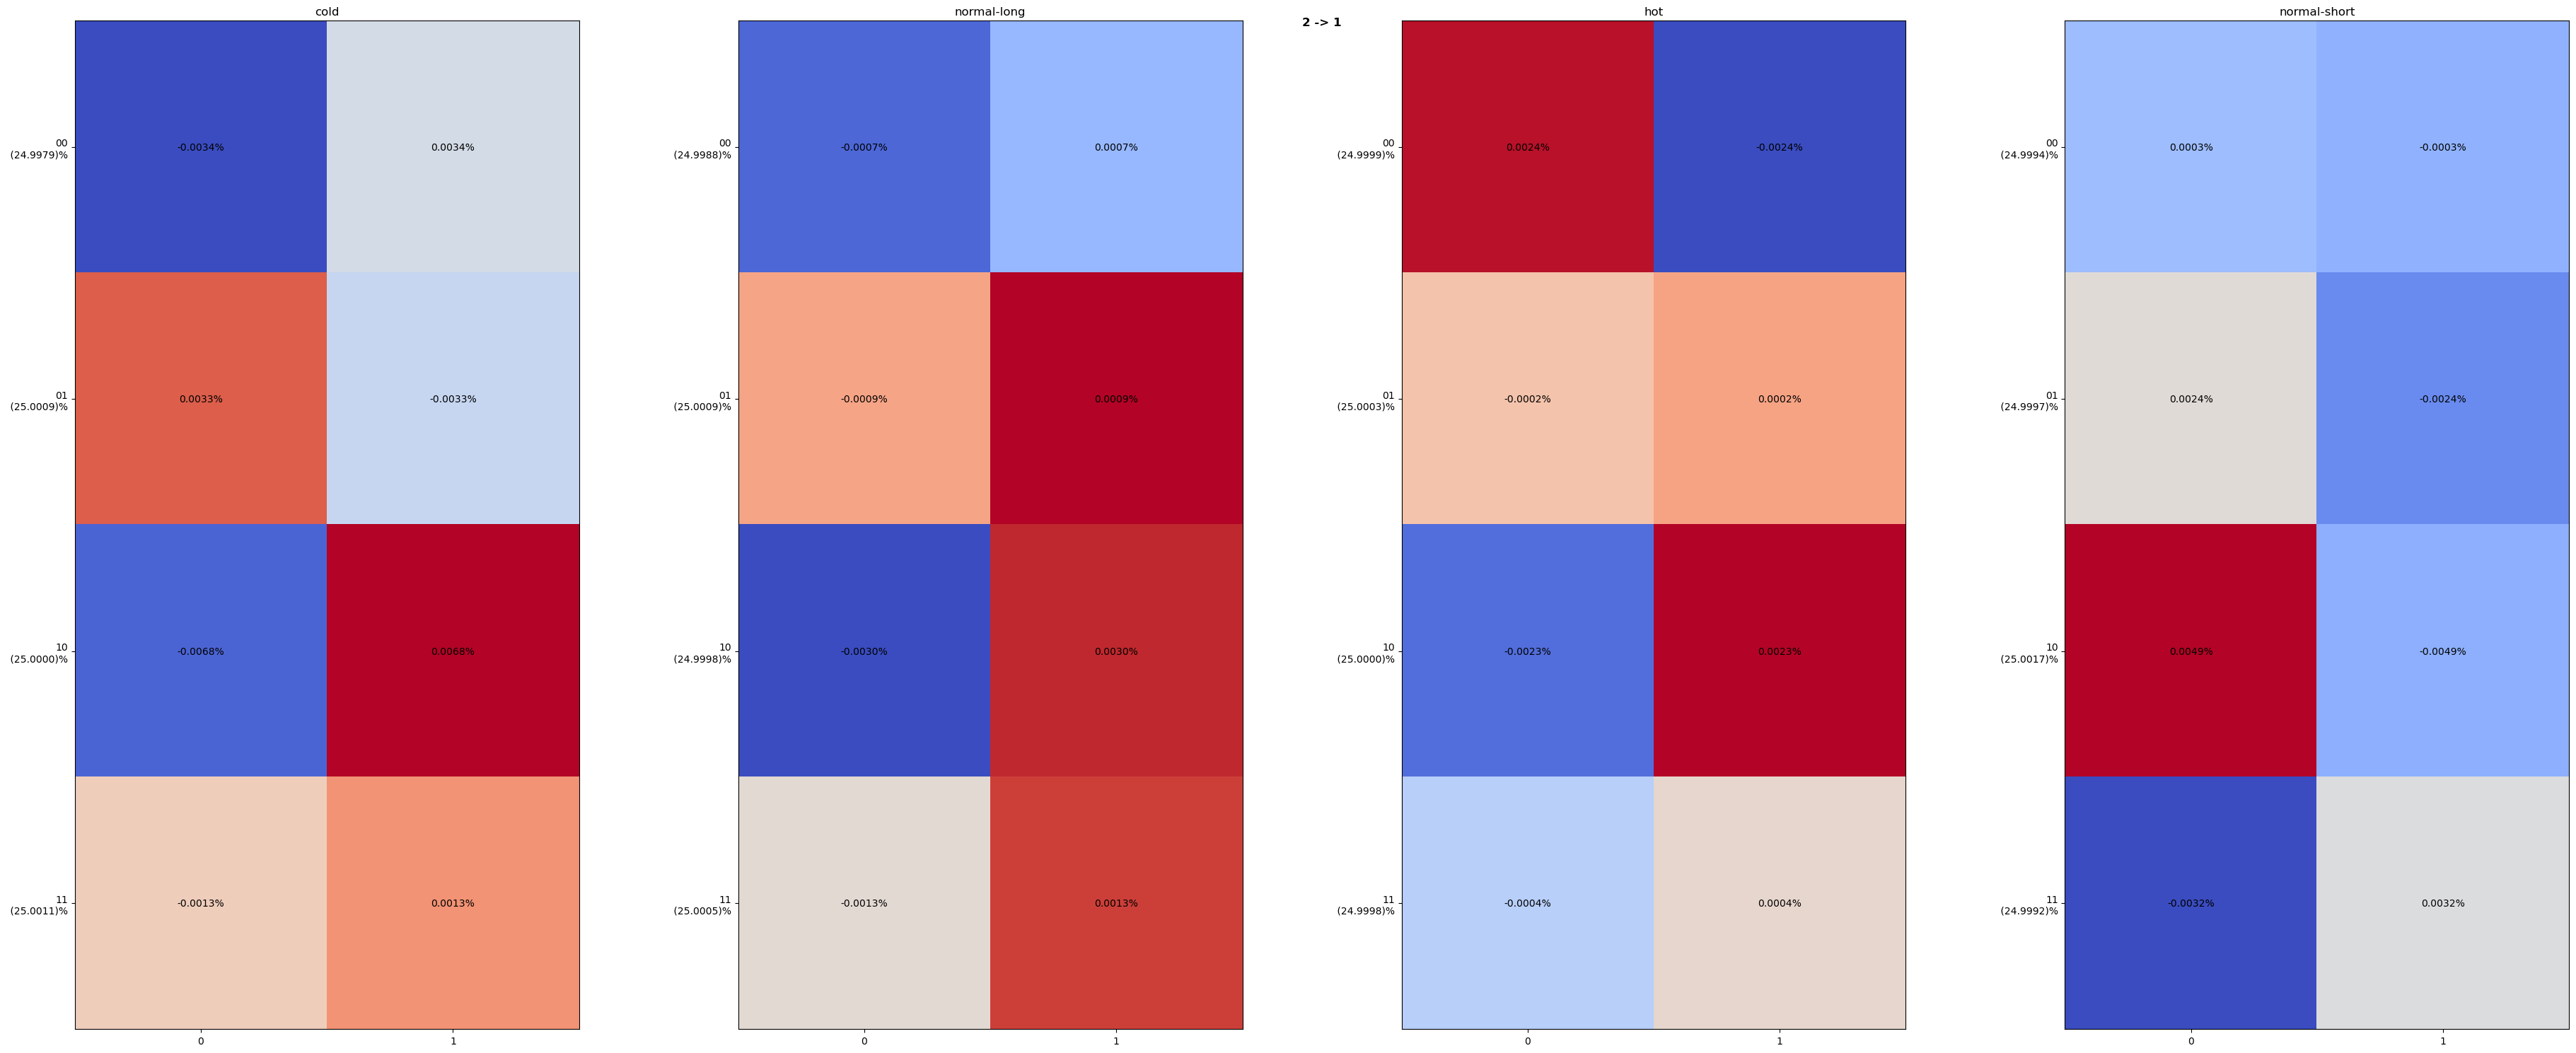

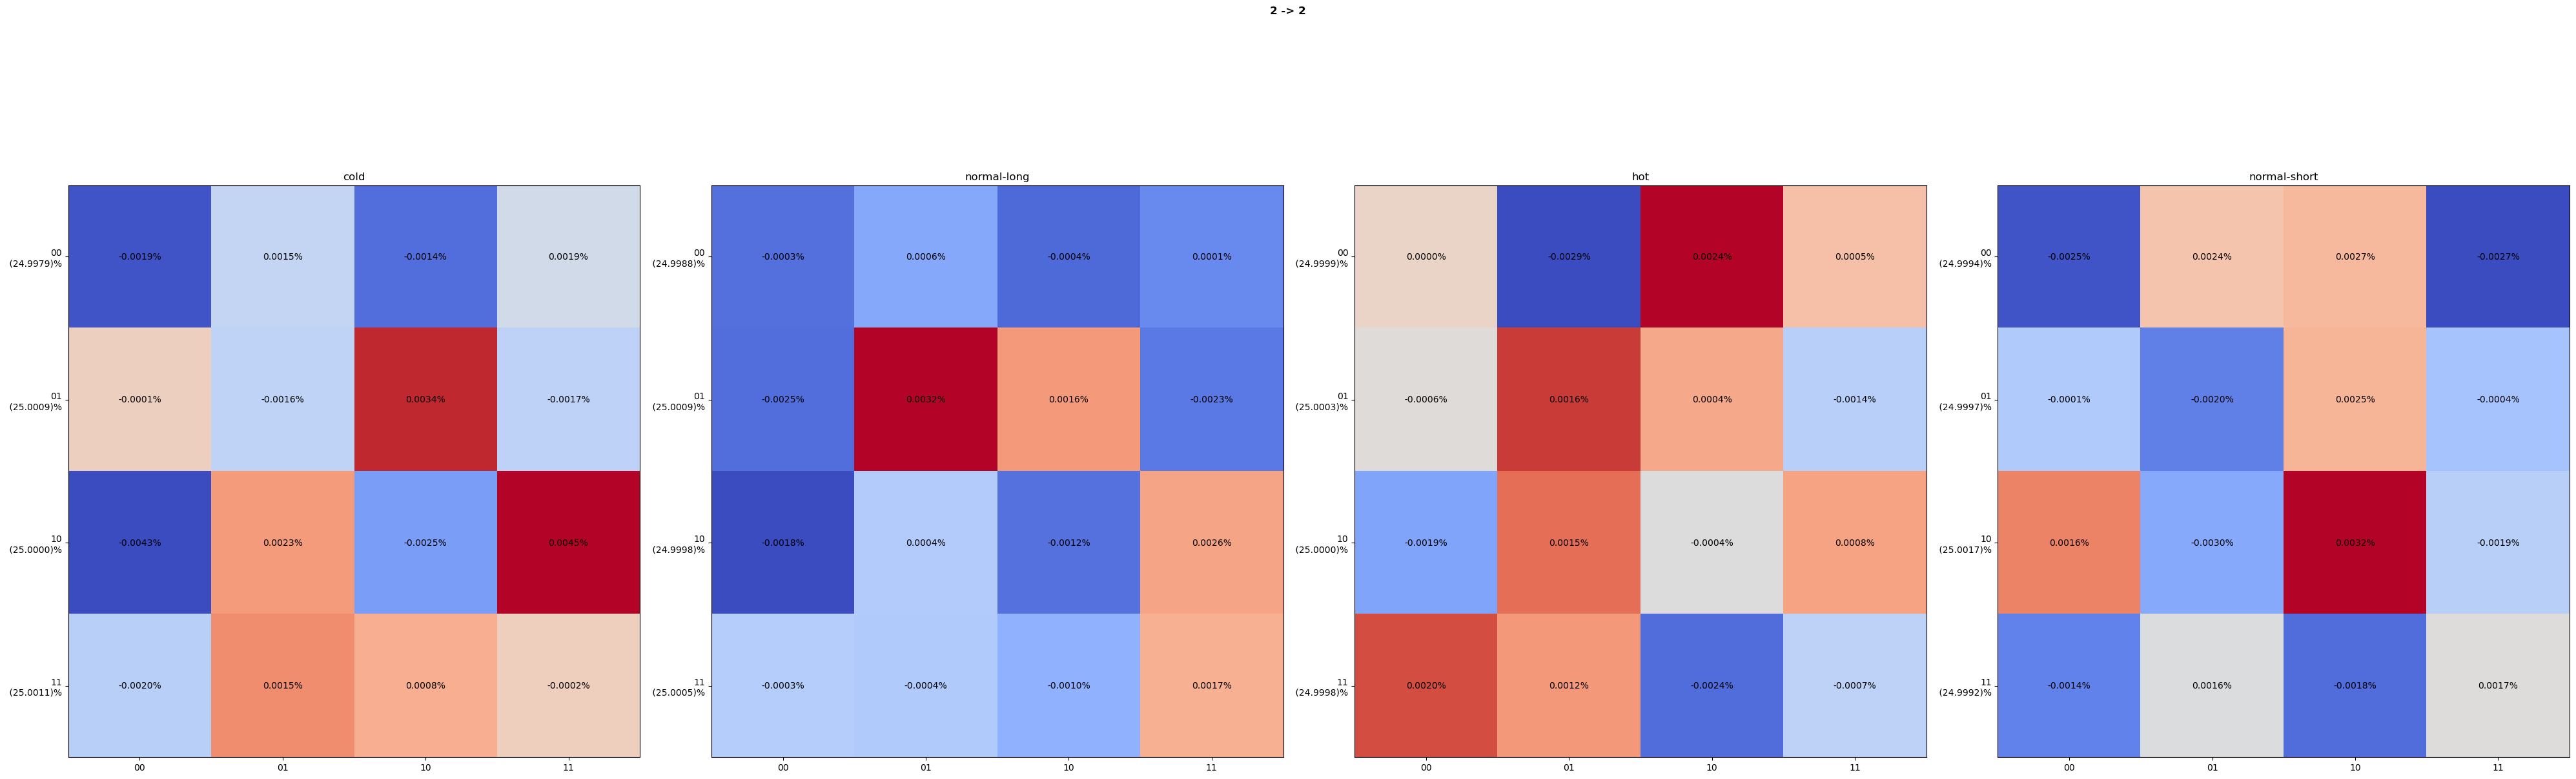

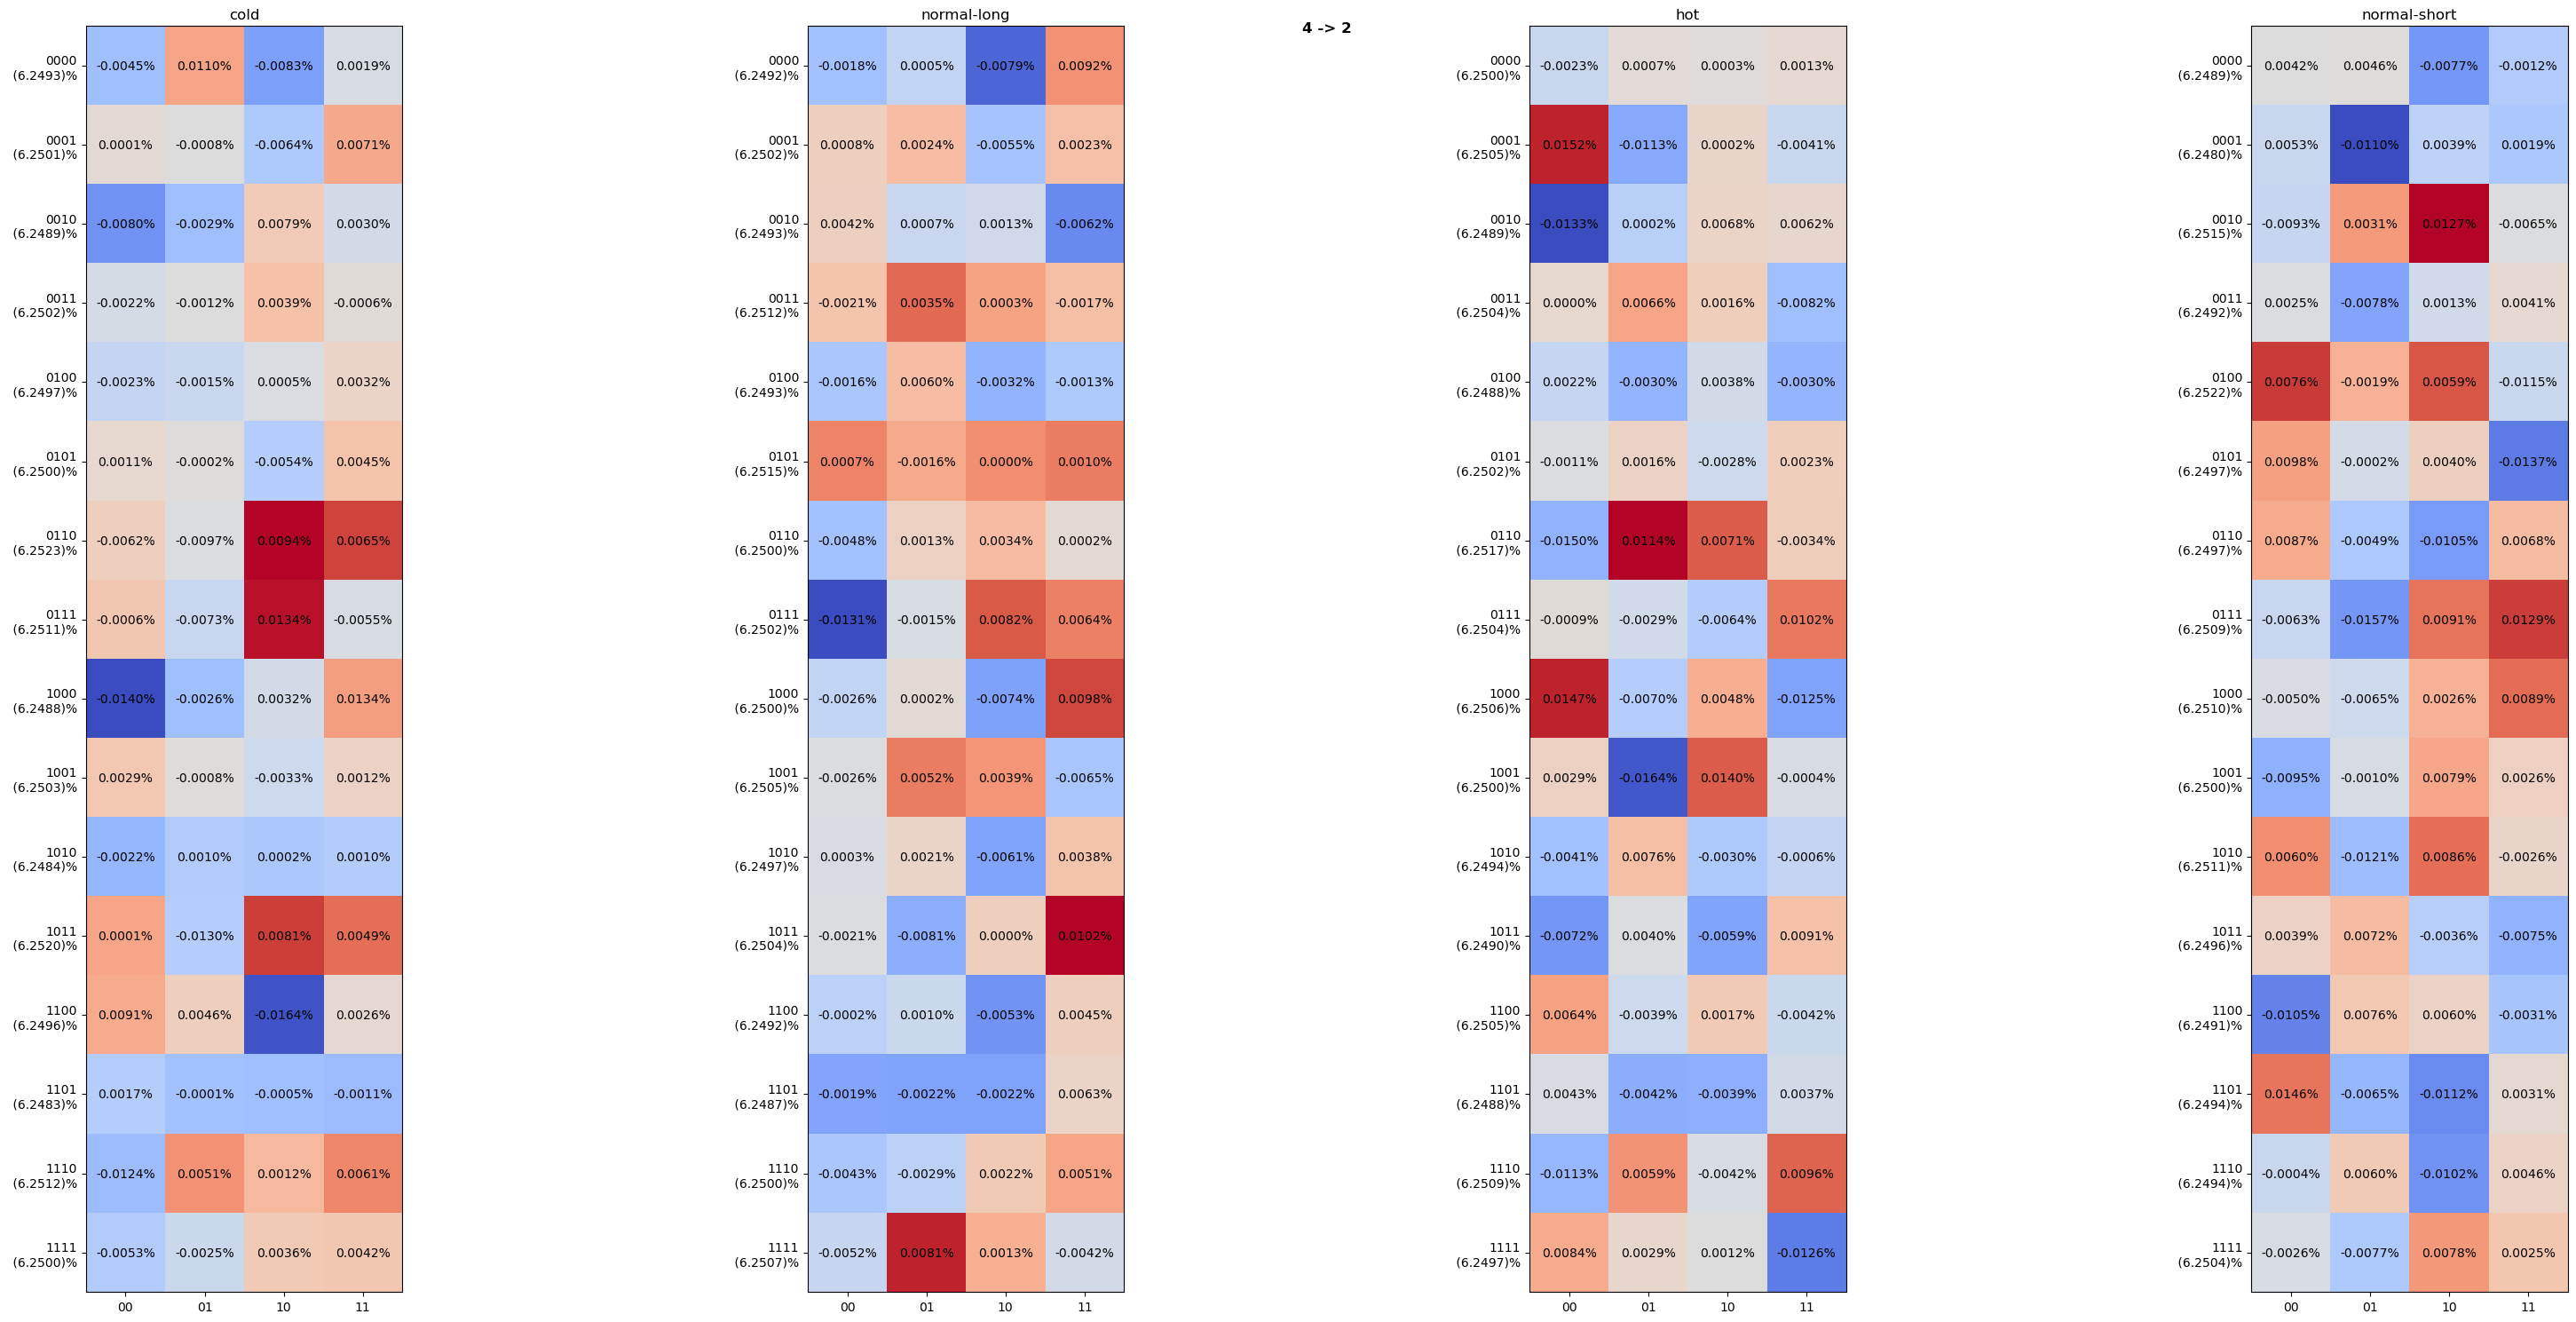

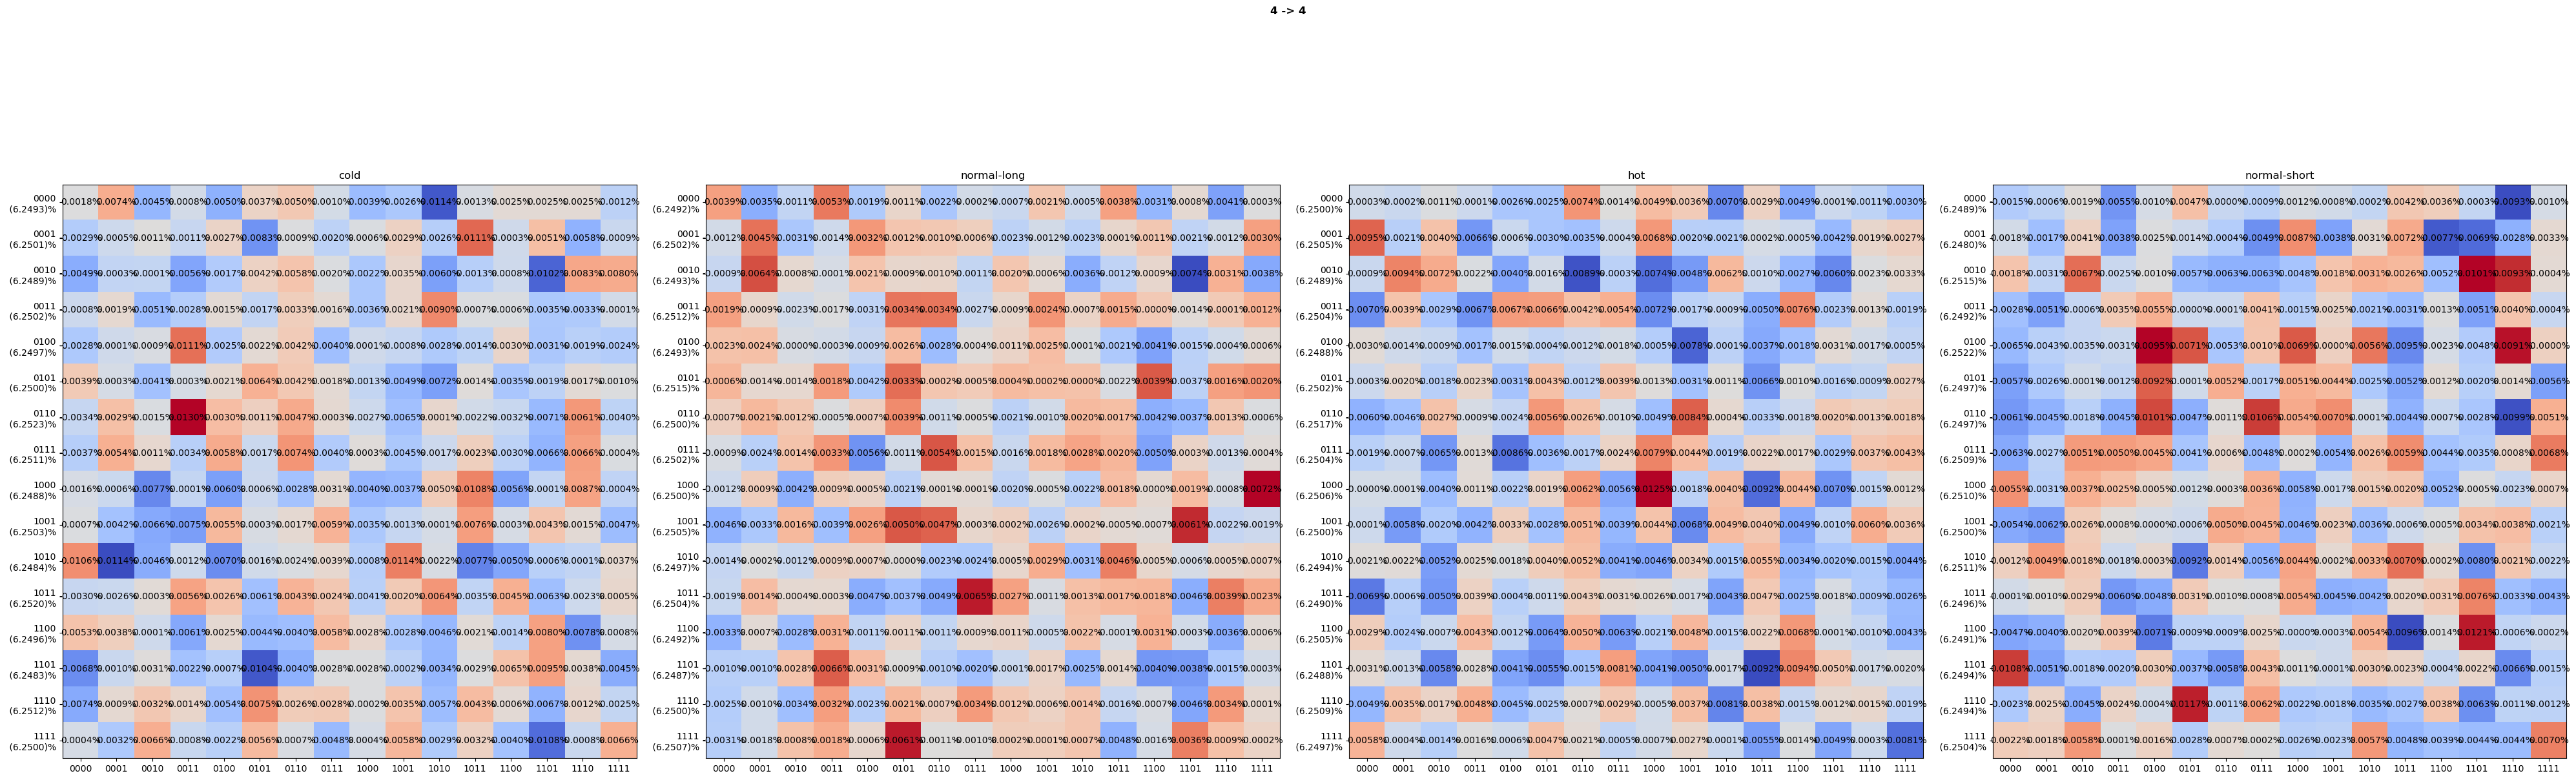

In [3]:
process_files(input_atecc108)

### Spracované vzorky LCG

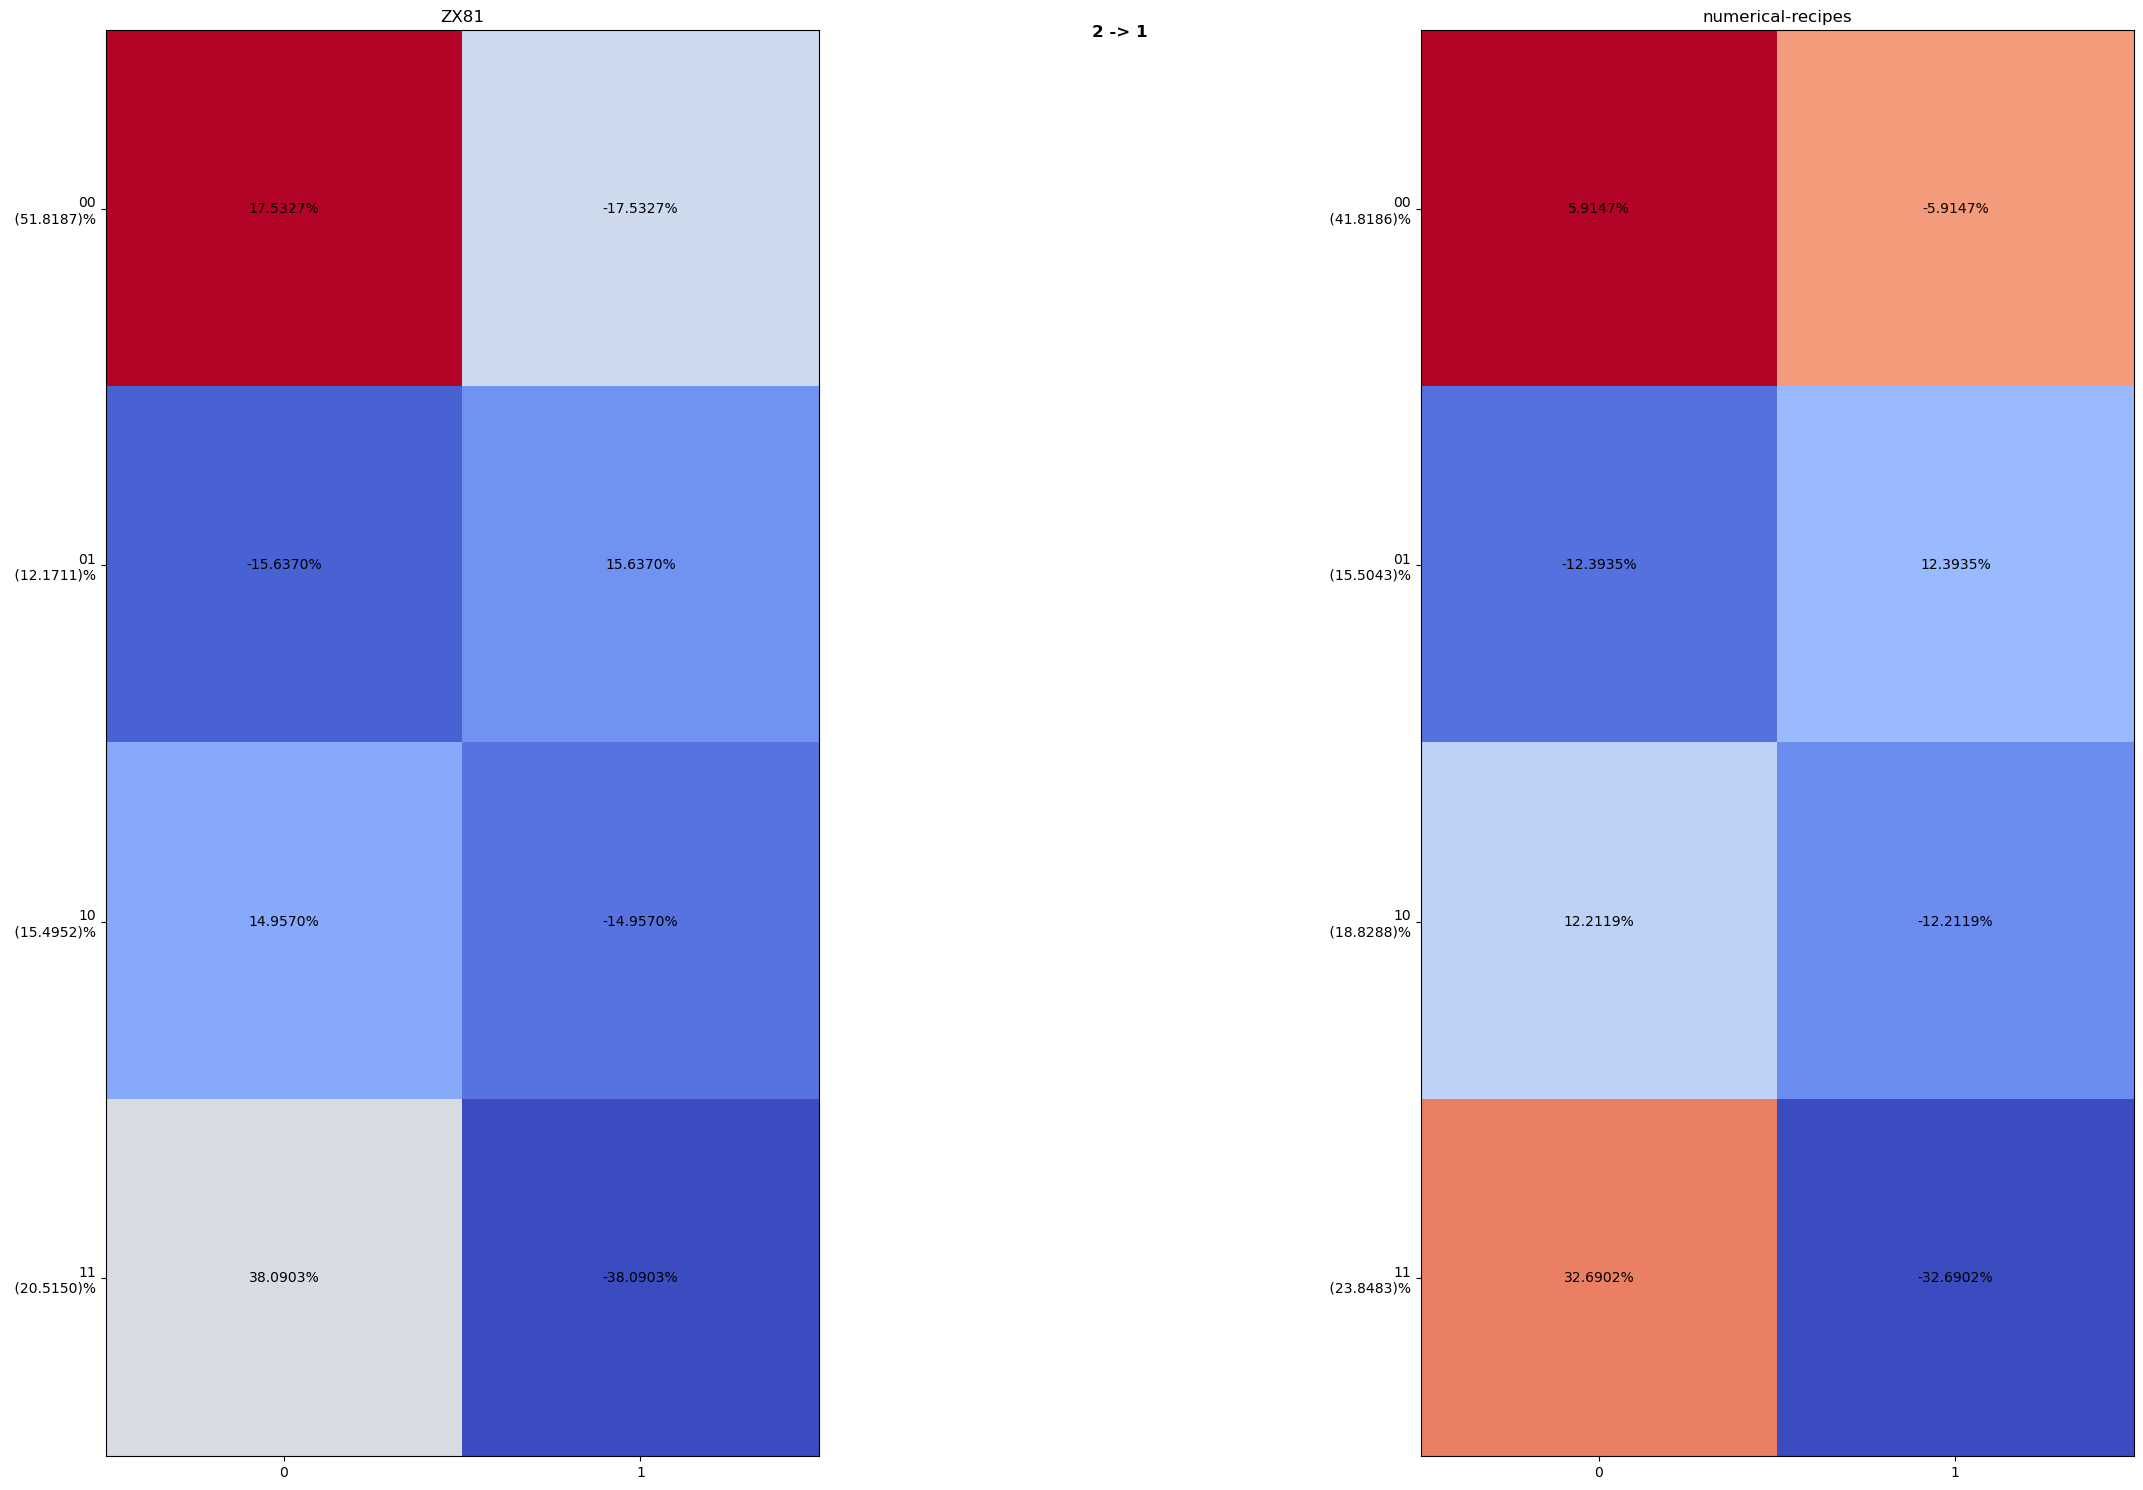

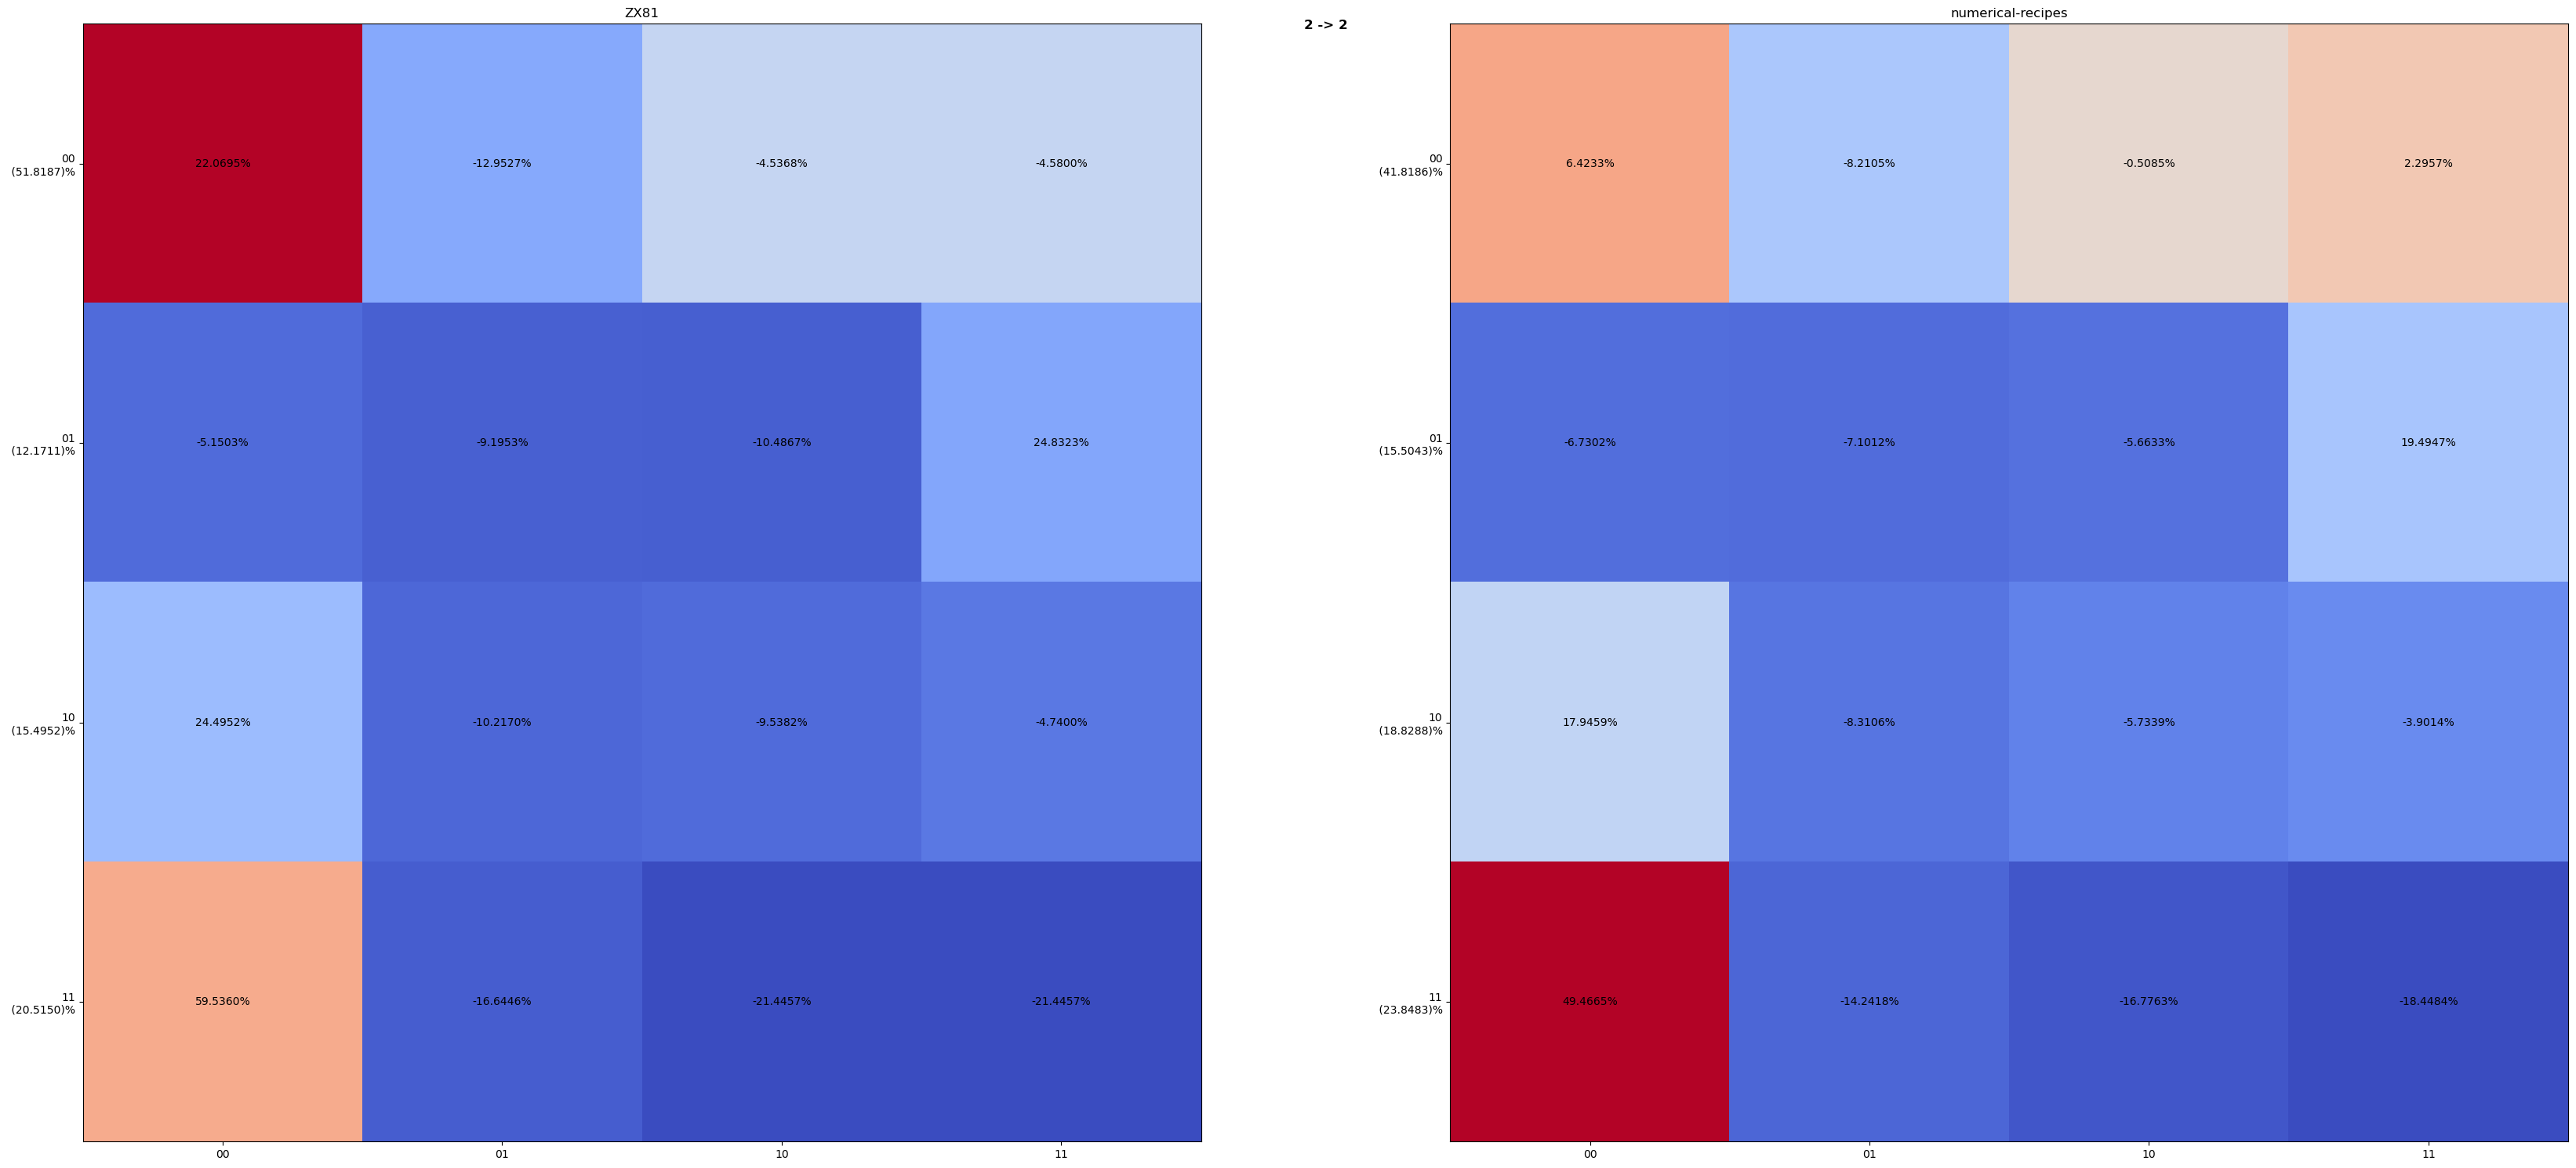

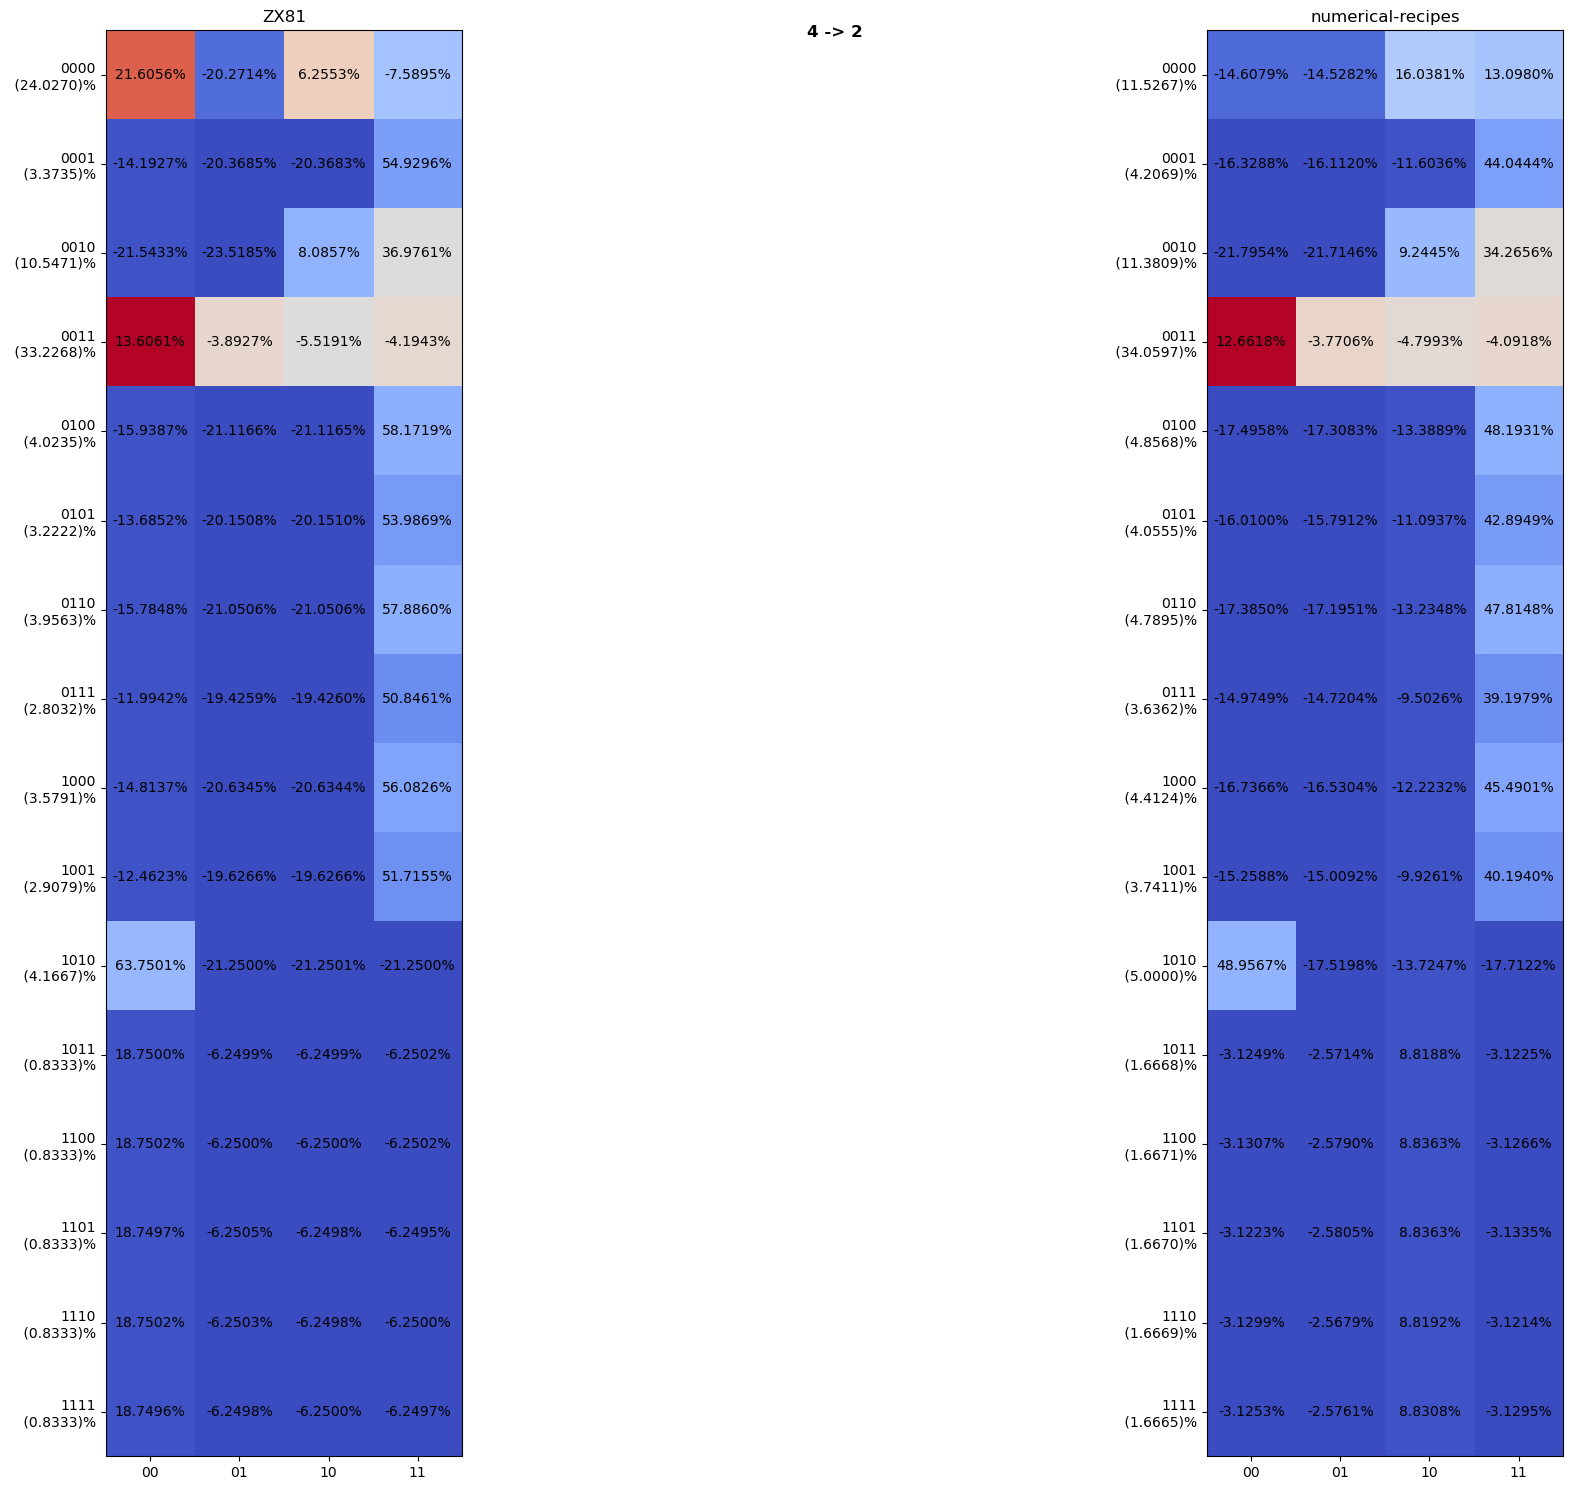

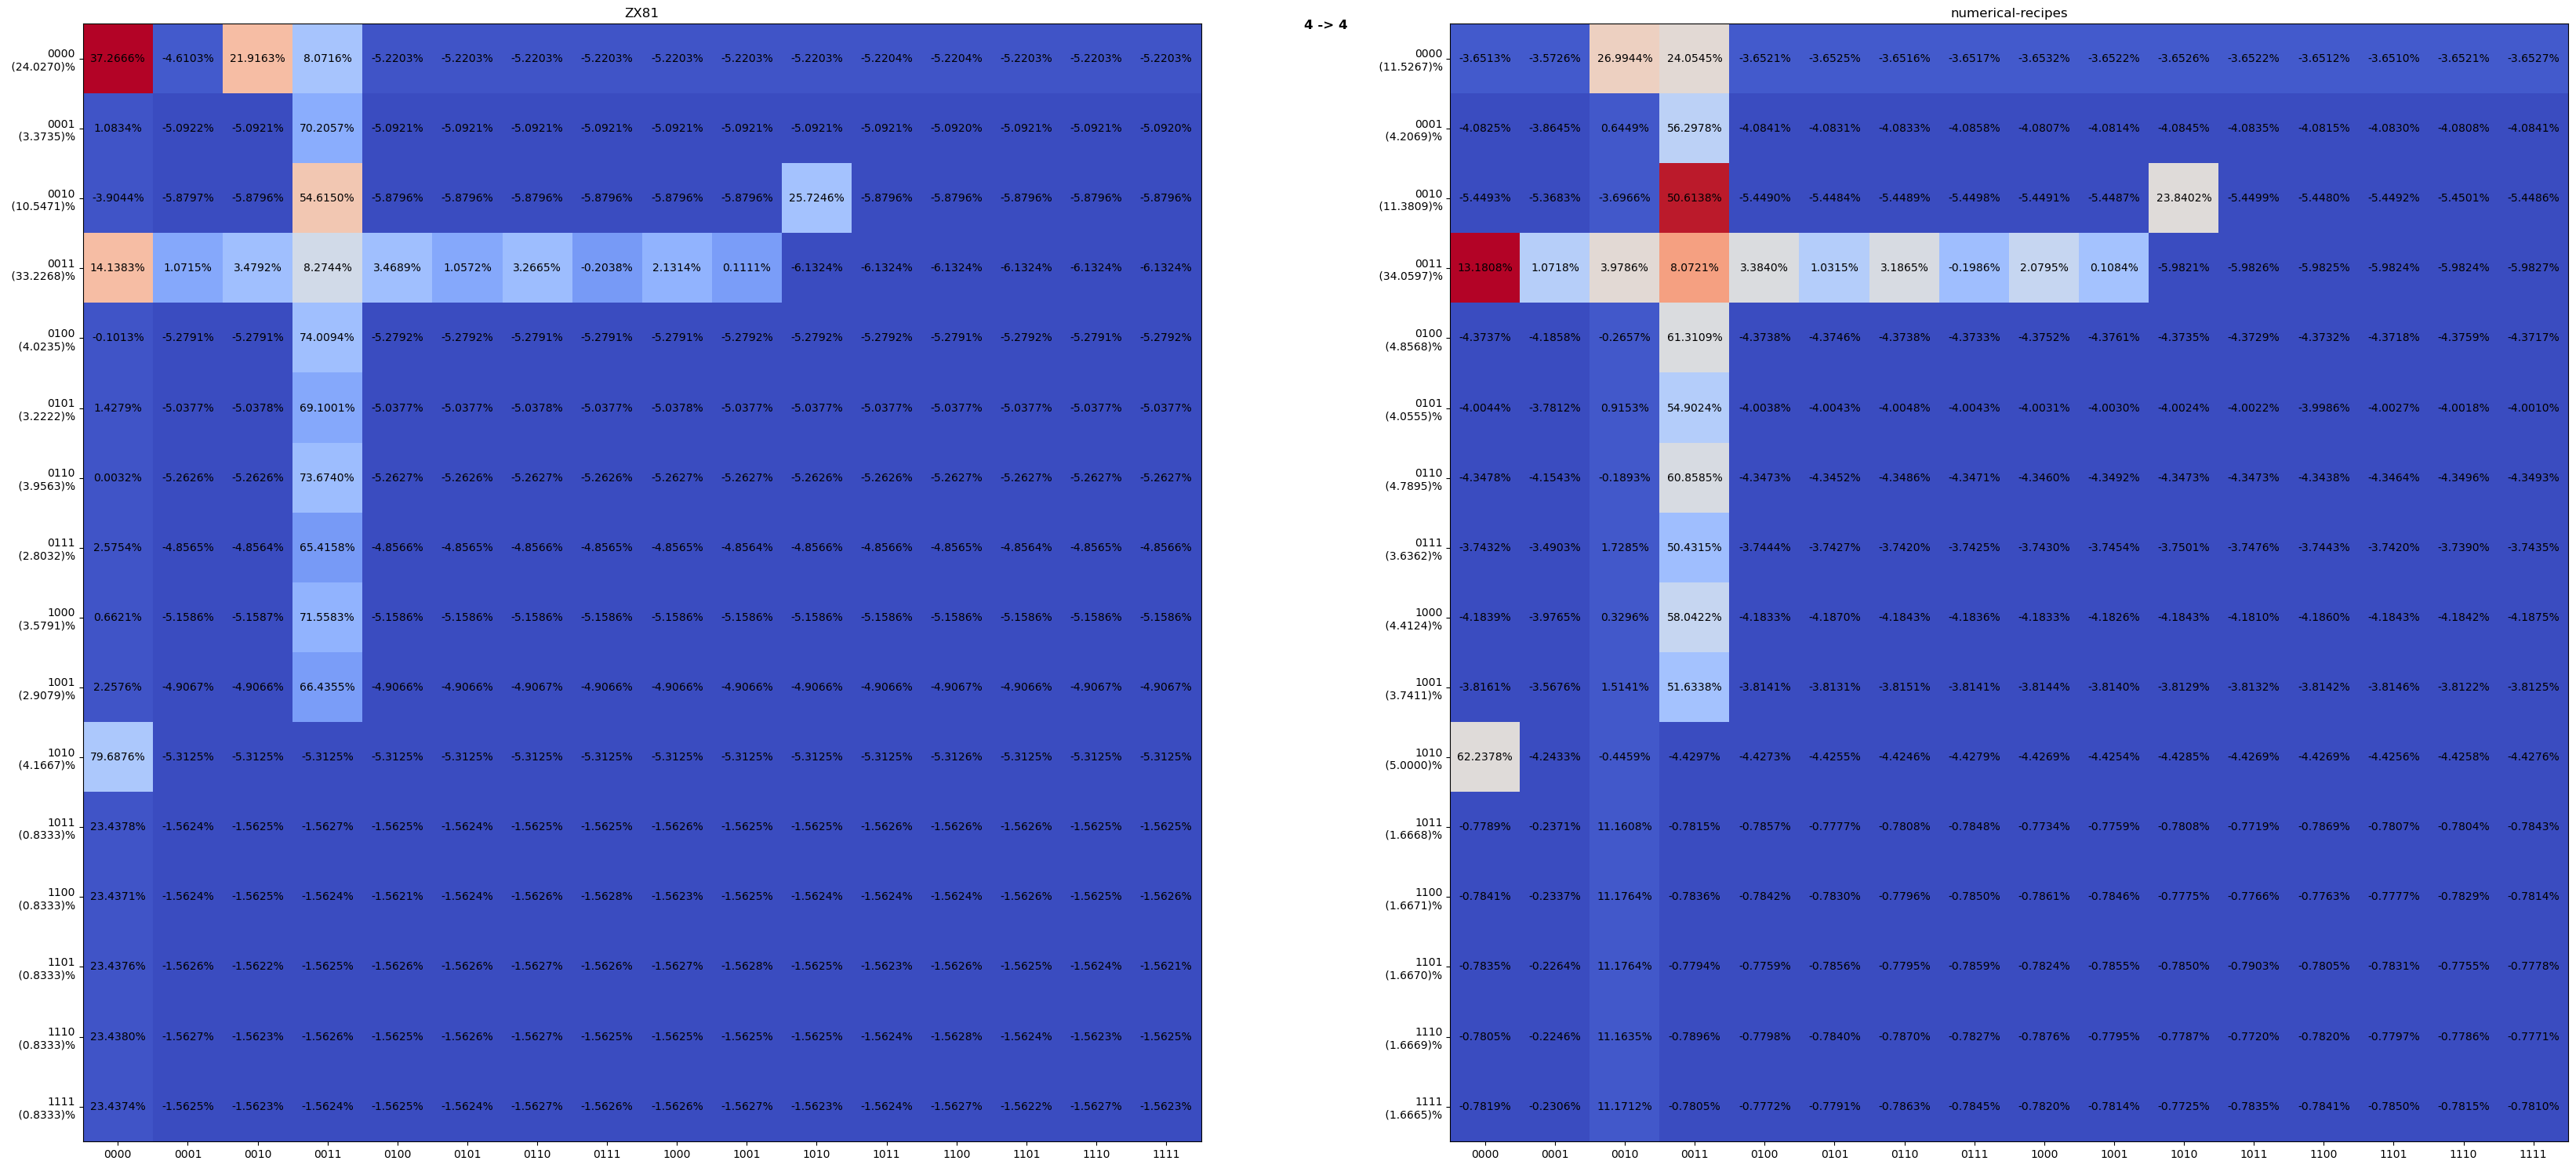

In [4]:
process_files(input_lcg)

### Popis grafov
#### Matice
* n->m je matica $n×m$, napr. 2->1 je matica $2×1$ 
* vypočítali sme štyri matice pre každú vzorku - $m_{2×1},m_{2×2},m_{4×2},m_{4×4}$
* na vrchu je názov vzorky

#### Os $x$
* na osi $x$ sa nachádza $m$-tica bitov
#### Os $y$
* na osi $y$ sa nachádza $n$-tica bitov
* percentá zobrazujú percentuálny podiel riadku zo všetkých porovnaní
* súčet percent na osi $y$ je $100\%$ 

#### Bunka $b_{n,m}$
* maticová bunka $b_{n,m}$ vyjadruje odchylku danej bunky v rámci riadku
* odchylka je rozdiel výskytu $n-m$-tice a očakávaného počtu $n-m$-tice v podieli súčtu všetkých $m$-tíc v riadku
    * majme maticu $2×1$, pozrieme sa dvojicu $00$-$0$
    * $\#_{expected_{m}}=1/2=0.5$ 
    * $b_{n,m}=134234434$
    * $\#_{total_{m_{00}}}=268486962$
    * potom $odchylka=\#_{expected_{m}} - \frac{b_{n,m}}{\#_{total_{m_{00}}}}=0.5 - \frac{134234434}{268486962}=0.00003369623=0.0034\%$
* súčet ochýlok v riadku je 0%

### Analýza a záver
#### LCG
U vzoriek vygenerovaných LCG je pekne vidieť najmä na matici $4×4$ náchylnosť generovať niektoré štvorice vo väčšom počte. Konkrétne, vo vzorke
* _numerical-recipes_ sa za 4-icou $0011$ sa dosť často vyskytovala 4-ica $0000$
* _XZ81_ sa za 4-icou $0000$ sa dosť často vyskytovala 4-ica $0000$

#### ATECC108
U vzoriek generovaných ATECC108 už takéto náchylnosti nemožno pozorovať - ani medzi rôznymi prostrediam. Odchylky od výskytov sú rádovo až v mikro percentách ($μ\%$) a celá matica je zafarbéna.

#### Výsledok
Pre generátor ATECC108 sme nespozorovali žiadnu signifikantnú zmenu medzi prostrediami. Zdá sa, že na škále 0°C až 40°C nedochádza k žiadnej zmene pri generovaní náhodných čísel.

#### v závere
Nenašli sme žiadne nezrovnalosti, preto usudzujeme, že bežné teploty okolitého prostredia nemajú vplyv na kvalitu generátora ATECC108.